

*   Set Desire Consumption



Data shape = (121273, 2)
13478.0


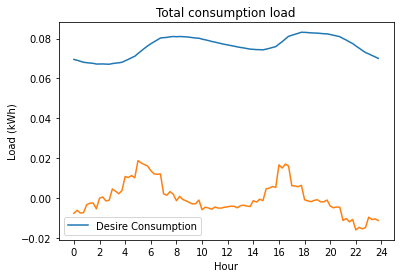

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from pandas import read_csv
import pandas as pd
import numpy as np
from random import uniform
import math

consumers_num = 30
# this is "K" in paper notation
hours_steps_num = 24
step = 4
time_steps = 24*step + 1
# initial price
p0 = 100

# load data
#filename = 'NI_hourly.csv'
filename = 'AEP_hourly.csv'

#names = ['Level3', 'Level5', 'Level7', 'Consumption', 'temp', 'Hour', 'Day_of_week',
#         'Day_of_month', 'month']
names = ['time', 'consumption']
data = pd.read_csv(filename)
print(f'Data shape = {data.shape}')
n_features = len(data.columns) - 1
array = data.values
cons = array[:, 1]
print(cons[0])
Y = array[:, n_features]
#Y = Y.astype(int)

# load that consumer i in time step k needs
real_load = np.zeros((consumers_num, time_steps))

std = 1
mean = 0
# generate a sample load that consumer i in time step k needs
for n in range(consumers_num):
  no = np.random.normal(mean, std, size=time_steps)
  for col in range(0, time_steps-1):
    h = (col//4)
    qua = col - 4*h
    real_load[n, col] = cons[h+n*24] + (qua*(cons[h+n*24+1] - cons[h+n*24])/4)
    real_load[n, col] = real_load[n, col]/66 + 0.6*no[col]
    #print(f'real_load[{n, col}] = {real_load[n, col]}')
  real_load[n, time_steps-1] = real_load[n, 0]


# total consumption initial load of system in time step k
s = np.zeros(time_steps)
d_s = np.zeros(time_steps)
for k in range(time_steps):
  s[k] = sum(real_load[:, k])
  if k > 0:
    d_s[k] = (s[k]-s[k-1])/s[k]
  #print(s[k])


ax = plt.axes(xscale='linear', yscale='linear')
plt.plot(np.arange(0, 24, 0.25), s[1:time_steps]/100000)
plt.plot(np.arange(0, 24, 0.25), d_s[1:time_steps])
ax.xaxis.set_major_locator(plt.MaxNLocator(14))
plt.legend(["Desire Consumption"])
plt.title("Total consumption load")
#plt.xlim(0, 24)
#plt.ylim(3000, 7700)
plt.xlabel("Hour")
plt.ylabel("Load (kWh)")
plt.show()




*  Gradient descent

---



In [ ]:

# set parameters regarding to paper
alpha = 0.05
theta = 3
gamma = 1
landa = 0.05

X = np.zeros((consumers_num, time_steps))
# iteration m
m_iteration = 9
landa_g = np.zeros(time_steps)
s_g = np.zeros(time_steps)
s_inf_g = np.zeros(time_steps)
p_g = np.zeros(time_steps)
p_g[0] = p0

for col in range(time_steps):
  s_inf_g[col] += ((2*theta*gamma*gamma*s[col]) - (consumers_num*p0)) / ((2*theta*gamma*gamma) + (landa*(consumers_num+1)))
for i in range(consumers_num):
  X[i, 0] = real_load[i, 0]/2
for h in range(1, time_steps):
  for n in range(consumers_num):
    mm = X[n, h-1]
    for j in range(m_iteration):
      X[n, h] = mm + alpha*(-2*theta*(gamma*gamma)*(mm - real_load[n, h]) - landa*mm - p_g[h-1])
      mm = X[n, h]
  L = sum(X[:, h])
  s_g[h] = L
  landa = (2*theta*(gamma**2)*(s[h] - L) - (consumers_num*p0))/((1+consumers_num)*L)
  p_g[h] = landa*L + p0
  landa_g[h] = landa






*   Newton-based algorithm

---



In [ ]:
# set parameters regarding to paper
theta = 3
gamma = 1
landa = 0.05
alpha = 1/(2*theta*(gamma*gamma)+2*landa)


landa_n = np.zeros(time_steps)
# total consumption equilibrium load of system in time step k
s_n = np.zeros(time_steps)
p_n = np.zeros(time_steps)
# AFTER FEEDBACK: load for consumer i in time step k
X_n = np.zeros((consumers_num, time_steps))

p_n[0] = p0
for n in range(consumers_num):
  X_n[n, 0] = real_load[n, 0]/2
s_n[0] = s[0]/2
for h in range(1, time_steps):
  for n in range(0, consumers_num):
    mm = X_n[n, h-1]
    X_n[n, h] = mm + alpha*(-2*theta*(gamma*gamma)*(mm-real_load[n, h]) - landa*mm - p_n[h-1])
  L = sum(X_n[:, h])
  landa = (2*theta*(gamma*gamma)*(s[h] - L) - (consumers_num*p0))/((1+consumers_num)*L)
  alpha = 1/(2*theta*(gamma*gamma)+2*landa)
  if (landa < 0):
    print(f'h = {h}, s = {s[h]} ~ L = {L} , price = {p_n[h]}, landa {landa}')
  #print(landa)
  p_n[h] = landa*L + p0
  s_n[h] = L
  landa_n[h] = landa

U_n = np.zeros(time_steps)
U_g = np.zeros(time_steps)
n = 1
for t in range(time_steps):
  #for n in range(consumers_num):
  U_n[t] += -1*(theta*((X_n[n, t] - real_load[n, t])**2) + p_n[t]*X_n[n, t])
  U_g[t] += -1*(theta*((X[n, t] - real_load[n, t])**2) + p_g[t]*X[n, t])




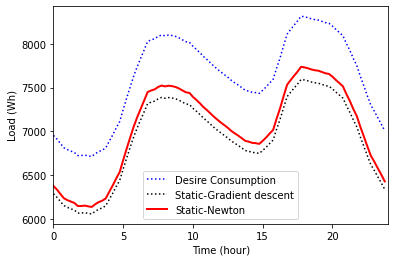

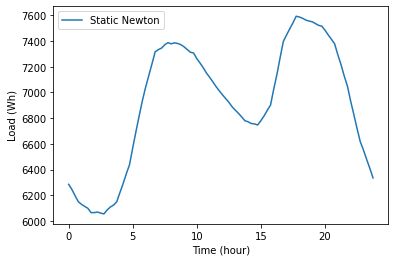

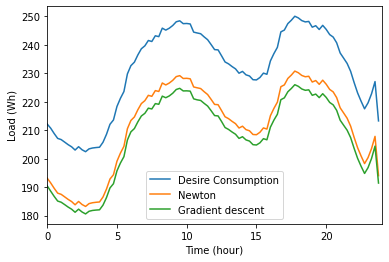

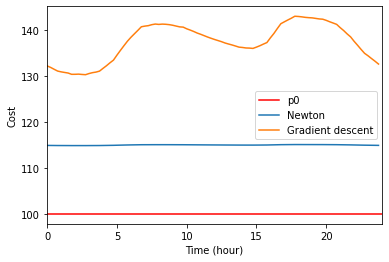

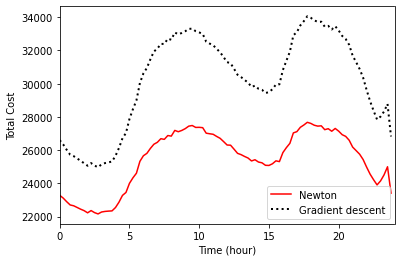

In [ ]:
#Result static

# plot the result

#ax = plt.axes(xscale='linear', yscale='linear')

plt.plot(np.arange(0, 24, 0.25), s[1: len(s)], 'b:')
plt.plot(np.arange(0, 24, 0.25), s_g[1: len(s_g)], 'k:')
plt.plot(np.arange(0, 24, 0.25), s_n[1: len(s_n)], 'r-', linewidth= 2)
ax.xaxis.set_major_locator(plt.MaxNLocator(14))
plt.legend(["Desire Consumption", "Static-Gradient descent", "Static-Newton"])
#plt.title("Total consumption load (Static)")
plt.xlim(0, 24)
#plt.ylim(3000, 6000)
plt.xlabel("Time (hour)")
plt.ylabel("Load (Wh)")
plt.show()

#ax = plt.axes(xscale='linear', yscale='linear')
plt.plot(np.arange(0, 24, 0.25), s_g[1: len(s_g)])
#ax.xaxis.set_major_locator(plt.MaxNLocator(14))
plt.legend(["Static Newton"])
#plt.title("Total consumption load (Static)")
#plt.xlim(0, 24)
#plt.ylim(2500, 6000)
plt.xlabel("Time (hour)")
plt.ylabel("Load (Wh)")
plt.show()


# plot the result
#ax = plt.axes(xscale='linear', yscale='linear')
plt.plot(np.arange(0, 24, 0.25), real_load[1, 1:time_steps])
plt.plot(np.arange(0, 24, 0.25), X_n[1, 1:time_steps])
plt.plot(np.arange(0, 24, 0.25), X[1, 1:time_steps])
ax.xaxis.set_major_locator(plt.MaxNLocator(14))
plt.legend(["Desire Consumption", "Newton", "Gradient descent"])
#plt.title("Consumption load for 1st consumer (Static Newton)")
plt.xlim(0, 24)
#plt.ylim(2500, 6000)
plt.xlabel("Time (hour)")
plt.ylabel("Load (Wh)")
plt.show()



# plot the result

#ax = plt.axes(xscale='linear', yscale='linear')
plt.axhline(y=p0, color='r', linestyle='-')
plt.plot(np.arange(0, 24, 0.25), p_n[1:len(p_n)])
plt.plot(np.arange(0, 24, 0.25), p_g[1:len(p_g)])
ax.xaxis.set_major_locator(plt.MaxNLocator(14))
plt.legend(['p0', "Newton", "Gradient descent"])
#plt.title("Price (Static)")
plt.xlim(0, 24)
#plt.ylim(3000, 6000)
plt.xlabel("Time (hour)")
plt.ylabel("Cost")
plt.show()


# plot the result
#ax = plt.axes(xscale='linear', yscale='linear')
plt.plot(np.arange(0, 24, 0.25), np.abs(U_n[1:len(U_n)]), 'r')
plt.plot(np.arange(0, 24, 0.25), np.abs(U_g[1:len(U_g)]), 'k:', linewidth= 2)
ax.xaxis.set_major_locator(plt.MaxNLocator(14))
plt.legend(["Newton", "Gradient descent"])
#plt.title("Sum of Utility in each time step (Static)")
plt.xlim(0, 24)
#plt.ylim(3000, 6000)
plt.xlabel("Time (hour)")
plt.ylabel("Total Cost")
plt.show()


In [ ]:
def fill_H(theta, landa, zeta, time_steps):
  mat_H = np.zeros((time_steps, time_steps))
  mat_H.fill(2*zeta/((2*theta+2*landa)**2 *(1 + 2*zeta*(time_steps-1)/(2*theta + 2*landa))))
  i = np.identity(time_steps)
  mat_H = mat_H + (-1/(2*theta+2*landa))*i
  #mat_H = np.linalg(mat_H)
  return mat_H

In [ ]:
def fill_G(V0, theta, landa, zeta, p_d, n, h):
  #print(p_d)
  #print(f'---- start fill_G with landa = {landa} ------')
  mat_G = np.zeros(time_steps)
  for i in range(1, time_steps):
    mat_G[i] = -2*theta*(V0[i] - real_load[n, i]) - landa*V0[i] - p_d[i-1] - 2*zeta*(sum(V0[h: time_steps]) - sum(real_load[n, h:time_steps]))
    #print(f'{-2*theta*(real_load[n, i] - V0[i])} + {-landa*V0[i]} + , {-p_d[i-1]} + {-2*zeta*(sum(real_load[n,:]) - sum(V0))} = {mat_G[i]}')
  return mat_G

In [ ]:
def third(Y_d, h):
  ans_real = 0;
  ans_equ = 0;
  for i in range(consumers_num):
    for j in range(h, time_steps):
      ans_real += real_load[i, j]
      ans_equ += Y_d[i, j]
  if (ans_real - ans_equ < 0 ):
    print(f'It has a problem {ans_real - ans_equ}')
  return (ans_real - ans_equ)

[100.         100.97405992 100.97454882 100.97495498 100.97536487
 100.97590805 100.97646708 100.97701645 100.97744828 100.97805185
 100.97865351 100.97916184 100.97965659 100.98032406 100.98091759
 100.9814305  100.98196338 100.98270904 100.983391   100.98405839
 100.9846355  100.98547276 100.98620637 100.9868489  100.98740138
 100.98780328 100.98808168 100.98828275 100.98841949 100.98812746
 100.98774006 100.98734213 100.98682228 100.98610785 100.98539004
 100.98453278 100.98356811 100.98248534 100.9812877  100.98000113
 100.97868406 100.97710068 100.97546258 100.97370847 100.97182827
 100.96987988 100.96780489 100.96561712 100.96333046 100.9609343
 100.95842916 100.95580044 100.95302196 100.95015308 100.94716197
 100.94402464 100.94074575 100.93742712 100.93394647 100.9303712
 100.92662643 100.92293045 100.91909656 100.915134   100.91100014
 100.90708172 100.90294392 100.89870395 100.89425903 100.88932174
 100.88420635 100.87890515 100.87344782 100.86758576 100.86152635
 100.8552729

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


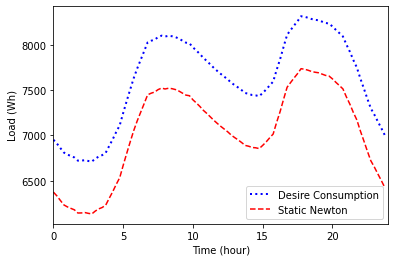

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


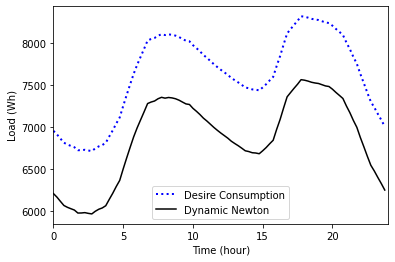

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


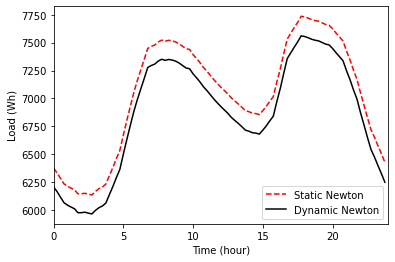

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


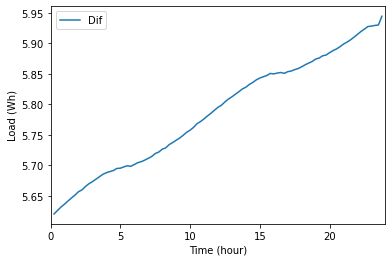

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


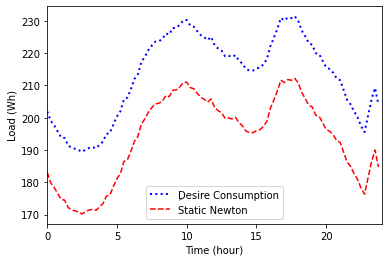

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:169: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


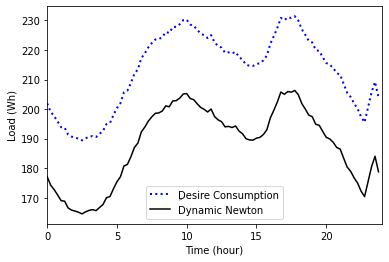

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:187: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


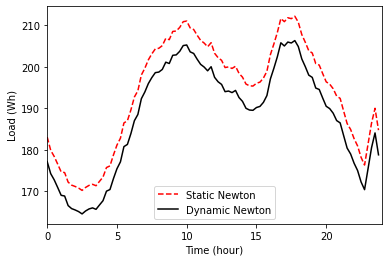

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


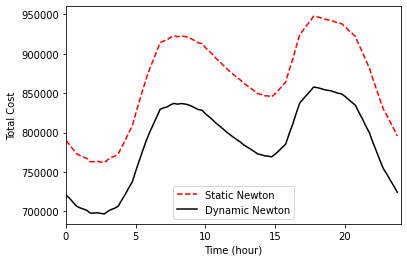

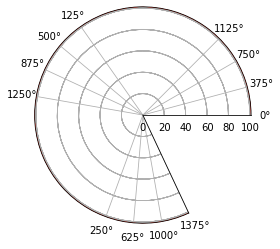

In [ ]:
# set parameters regarding to paper
theta = 2
gamma = 1
landa = 0.005
zeta = 0.0003

theta = theta * gamma * gamma

mat_H = fill_H(theta, landa, zeta, time_steps)
mat_G = np.zeros((time_steps))

s_d = np.zeros(time_steps)
p_d = np.zeros(time_steps)
landa_d = np.zeros(time_steps)
# AFTER FEEDBACK: load for consumer i in time step k
X_d = np.zeros((consumers_num, time_steps))

for i in range(time_steps):
  p_d[i] = p_n[i]

for i in range(consumers_num):
  for j in range(time_steps):
    X_d[i, j] = X_n[i, j]

for h in range(1, time_steps):
  mat_H = fill_H(theta, landa, zeta, time_steps)
  #print(f'--------------- {h} ------------------')
  #print((mat_H))
  for n in range(consumers_num):
    V0 = np.zeros(time_steps)
    V0[1:time_steps] = X_d[n, 1:time_steps]
    #V0[h:time_steps] = X_n[n, h:time_steps]
    #print(f'start')
    for t in range(1):
      mat_G = fill_G(V0, theta, landa, zeta, p_d, n, h)
      #mat_G = np.transpose(mat_G)
      #print(mat_G)
      #print(f'shape = {np.shape(mat_G)}')
      ans = np.matmul(mat_H, mat_G)
      V = np.transpose(V0) - ans
      #print(f' V = {V[1]} V0 = {V0[1]} ans = {ans[1]}')
      V0[h:time_steps] = V[h:time_steps]
    #X_d[n, h] = V0[h]
    X_d[n, h:time_steps] = V0[h:time_steps]

    #print(f'X = {X_d[n,h]}')
  L = sum(X_d[:, h])
  landa = (2*theta*(s[h] - L) - (consumers_num*p0) + 2*zeta*(third(X_d, h)))/((1+consumers_num)*L)
  #landa = 0.005
  p_d[h] = landa*L + p0
  landa_d[h] = landa
  if (landa < 0):
    print(f'{h} ----- {2*theta*(s[h] - L)} + {2*zeta*(third(X_d, h))} - {(consumers_num*p0)} = {landa}')
  s_d[h] = L

print(p_d)
print(p_n)
U_s_n = np.zeros(time_steps)
U_d_n = np.zeros(time_steps)
n = 1
U1 = 0
U2 = 0
for t in range(1, time_steps):
  U1 += -1*(theta*((X_d[n, t] - real_load[n, t])**2) + p_d[t]*X_d[n, t] + zeta*(sum(X_d[n, :]) - sum(real_load[n, :]))**2)
  U2 += -1*(theta*((X_n[n, t] - real_load[n, t])**2) + p_n[t]*X_n[n, t] + zeta*(sum(X_n[n, :]) - sum(real_load[n, :]))**2)
print((U1-U2)/U1)
for n in range(consumers_num):
  for t in range(1, time_steps):
    U_d_n[t] += -1*(theta*((X_d[n, t] - real_load[n, t])**2) + p_d[t]*X_d[n, t] + zeta*(sum(X_d[n, :]) - sum(real_load[n, :]))**2)
    U_s_n[t] += -1*(theta*((X_n[n, t] - real_load[n, t])**2) + p_n[t]*X_n[n, t] + zeta*(sum(X_n[n, :]) - sum(real_load[n, :]))**2)

a1 = sum(U_d_n)
a2 = sum(U_s_n)
print((a1-a2)/a1)
print(U_d_n[1], U_s_n[1])

#ax = plt.axes(xscale='linear', yscale='linear')

plt.plot(np.arange(0, 24, 0.25), s[1: time_steps], 'b:', linewidth=2)
plt.plot(np.arange(0, 24, 0.25), s_n[1: time_steps], 'r--')
#plt.plot(np.arange(0, 24, 0.25), s_d[1: time_steps], 'k')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.legend(["Desire Consumption", "Static Newton"])
#plt.title(f'Total Consumption load (Dynamic)')
axes= plt.axes()
#line =  np.linspace(0, 24*60, num=24*4, endpoint=False)
#print(line)
#axes.set_xticks()
plt.xlim(0, 24)
plt.xlabel("Time (hour)")
plt.ylabel("Load (Wh)")
plt.show()

plt.plot(np.arange(0, 24, 0.25), s[1: time_steps], 'b:', linewidth=2)
#plt.plot(np.arange(0, 24, 0.25), s_n[1: time_steps], 'r--')
plt.plot(np.arange(0, 24, 0.25), s_d[1: time_steps], 'k')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.legend(["Desire Consumption", "Dynamic Newton"])
#plt.title(f'Total Consumption load (Dynamic)')
axes= plt.axes()
#line =  np.linspace(0, 24*60, num=24*4, endpoint=False)
#print(line)
#axes.set_xticks()
plt.xlim(0, 24)
plt.xlabel("Time (hour)")
plt.ylabel("Load (Wh)")
plt.show()


#plt.plot(np.arange(0, 24, 0.25), s[1: time_steps], 'b:', linewidth=2)
plt.plot(np.arange(0, 24, 0.25), s_n[1: time_steps], 'r--')
plt.plot(np.arange(0, 24, 0.25), s_d[1: time_steps], 'k')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.legend(["Static Newton", "Dynamic Newton"])
#plt.title(f'Total Consumption load (Dynamic)')
axes= plt.axes()
#line =  np.linspace(0, 24*60, num=24*4, endpoint=False)
#print(line)
#axes.set_xticks()
plt.xlim(0, 24)
plt.xlabel("Time (hour)")
plt.ylabel("Load (Wh)")
plt.show()


#ax = plt.axes(xscale='linear', yscale='linear')
plt.plot(np.arange(0.25, 24, 0.25), np.abs(X_d[1, 2: time_steps]-X_n[1, 2: time_steps]))
ax.xaxis.set_major_locator(plt.MaxNLocator(14))
plt.legend(["Dif"])
#plt.title('|Static Newton - Dynamic Newton|')
axes= plt.axes()
#line =  np.linspace(0, 24*60, num=24*4, endpoint=False)
#print(line)
plt.xlim(0, 24)
plt.xlabel("Time (hour)")
plt.ylabel("Load (Wh)")
plt.show()

#print(X_d[1, 1:time_steps] - X_n[1, 1:time_steps])

# plot the result
for i in range(1):#consumers_num):
  #ax = plt.axes(xscale='linear', yscale='linear')
  plt.plot(np.arange(0, 24, 0.25), real_load[i, 1: time_steps], 'b:', linewidth=2)
  #plt.plot(np.arange(0, 24, 0.25), (X_n[i, 1: time_steps] + X_d[i, 1: time_steps])/2)
  plt.plot(np.arange(0, 24, 0.25), X_n[i, 1: time_steps], 'r--')
  #plt.plot(np.arange(0, 24, 0.25), X_d[i, 1: time_steps], 'k')
  #ax.xaxis.set_major_locator(plt.MaxNLocator(14))
  plt.legend(["ِDesire Consumption", "Static Newton"])
  #plt.title(f'Consumption load of {i+1}st consumer')
  axes= plt.axes()
  plt.xlim(0, 24)
#line =  np.linspace(0, 24*60, num=24*4, endpoint=False)
#print(line)
#axes.set_xticks()
  #plt.xlim(0, 23*4)
  plt.xlabel("Time (hour)")
  plt.ylabel("Load (Wh)")
  plt.show()

  #ax = plt.axes(xscale='linear', yscale='linear')
  plt.plot(np.arange(0, 24, 0.25), real_load[i, 1: time_steps], 'b:', linewidth=2)
  #plt.plot(np.arange(0, 24, 0.25), (X_n[i, 1: time_steps] + X_d[i, 1: time_steps])/2)
  #plt.plot(np.arange(0, 24, 0.25), X_n[i, 1: time_steps], 'r--')
  plt.plot(np.arange(0, 24, 0.25), X_d[i, 1: time_steps], 'k')
  #ax.xaxis.set_major_locator(plt.MaxNLocator(14))
  plt.legend(["ِDesire Consumption", "Dynamic Newton"])
  #plt.title(f'Consumption load of {i+1}st consumer')
  axes= plt.axes()
  plt.xlim(0, 24)
#line =  np.linspace(0, 24*60, num=24*4, endpoint=False)
#print(line)
#axes.set_xticks()
  #plt.xlim(0, 23*4)
  plt.xlabel("Time (hour)")
  plt.ylabel("Load (Wh)")
  plt.show()

  #ax = plt.axes(xscale='linear', yscale='linear')
  #plt.plot(np.arange(0, 24, 0.25), real_load[i, 1: time_steps], 'b:', linewidth=2)
  #plt.plot(np.arange(0, 24, 0.25), (X_n[i, 1: time_steps] + X_d[i, 1: time_steps])/2)
  plt.plot(np.arange(0, 24, 0.25), X_n[i, 1: time_steps], 'r--')
  plt.plot(np.arange(0, 24, 0.25), X_d[i, 1: time_steps], 'k')
  #ax.xaxis.set_major_locator(plt.MaxNLocator(14))
  plt.legend(["Static Newton", "Dynamic Newton"])
  #plt.title(f'Consumption load of {i+1}st consumer')
  axes= plt.axes()
  plt.xlim(0, 24)
#line =  np.linspace(0, 24*60, num=24*4, endpoint=False)
#print(line)
#axes.set_xticks()
  #plt.xlim(0, 23*4)
  plt.xlabel("Time (hour)")
  plt.ylabel("Load (Wh)")
  plt.show()

#ax = plt.axes(xscale='linear', yscale='linear')
plt.plot(np.arange(0, 24, 0.25), abs(U_s_n[1:time_steps]), 'r--')
plt.plot(np.arange(0, 24, 0.25), abs(U_d_n[1:time_steps]), 'k')
ax.xaxis.set_major_locator(plt.MaxNLocator(14))
plt.legend(["Static Newton", "Dynamic Newton"])
#plt.title(f'Sum of Utility for each consumer')
axes= plt.axes()
#axes.set_xticks()
#plt.xlim(0, 30)
plt.xlim(0, 24)
plt.xlabel("Time (hour)")
plt.ylabel("Total Cost")
plt.show()


# Compute pie slices
label = np.arange(0, 24, 0.25)

N = len(label)
theta1 = np.linspace(0, 2*np.pi, N)
radii = p_d[1:time_steps]/100

#ax1 = plt.subplot(111, polar=True)

#ax1.plot(theta1, radii)

#width = np.pi / 4 * np.random.rand(N)
#colors = plt.cm.viridis(radii / 10.)

ax = plt.subplot(111, projection='polar')
ax.bar(theta1, radii, bottom=100, color='xkcd:salmon')
ax.set_xticks(np.linspace(0, 24, 12))
plt.grid(True)
plt.show()



*   RESULT

---



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


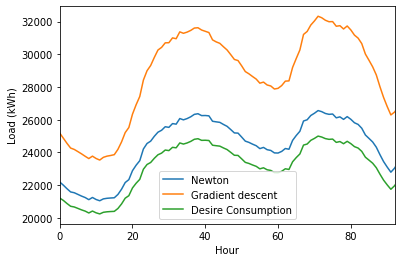

In [ ]:
cost_n = np.zeros((consumers_num, time_steps))
cost_g = np.zeros((consumers_num, time_steps))
cost = np.zeros((consumers_num, time_steps))
for j in range(time_steps):
  for i in range(consumers_num):
    cost_n[i, j] = X_n[i, j]*p_n[j]
    cost_g[i, j] = X[i, j]*p_g[j]
    cost[i, j] = real_load[i, j]*p0

# plot the result
plt.plot(cost_n[1, 1: (time_steps)])
plt.plot(cost_g[1, 1: ((time_steps))])
plt.plot(cost[1, 1: ((time_steps))])
plt.legend(["Newton", "Gradient descent", "Desire Consumption"])
#plt.title("Total consumption load")
axes= plt.axes()
plt.xlim(0, 23*4)
plt.xlabel("Hour")
plt.ylabel("Load (kWh)")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


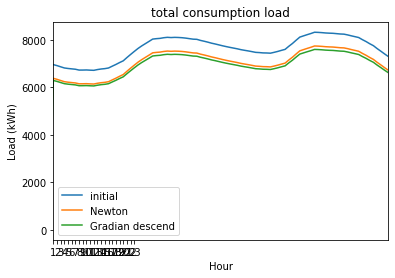

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


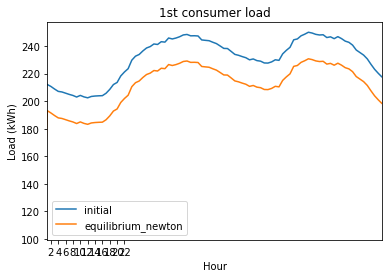

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


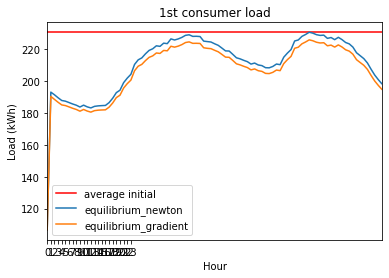

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


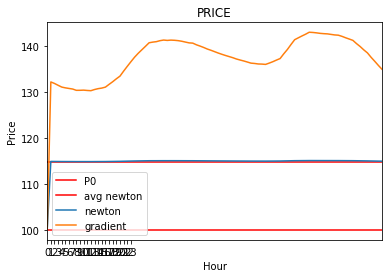

In [ ]:
# plot the result
plt.plot(s)
plt.plot(s_n)
plt.plot(s_g)
plt.legend(["initial", "Newton", "Gradian descend"])
plt.title("total consumption load")
axes= plt.axes()
axes.set_xticks(range(24))
plt.xlim(1, 23*4)
plt.xlabel("Hour")
plt.ylabel("Load (kWh)")
plt.show()


# plot the result
plt.plot(real_load[1, :])
plt.plot(X_n[1, :])
plt.legend(["initial", "equilibrium_newton"])
plt.title("1st consumer load")
axes= plt.axes()
axes.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22])
#axes.set_xticks(range(24))
plt.xlim(1, 23*4)
plt.xlabel("Hour")
plt.ylabel("Load (kWh)")
plt.show()

# plot the result
avg_num = sum(real_load[1, :])/len(real_load[1, :])
plt.axhline(y=avg_num, color='r', linestyle='-')
plt.plot(X_n[1, :])
plt.plot(X[1, :])
plt.legend(["average initial", "equilibrium_newton", "equilibrium_gradient"])
plt.title("1st consumer load")
axes= plt.axes()
axes.set_xticks(range(24))
plt.xlim(0, 23*4)
plt.xlabel("Hour")
plt.ylabel("Load (kWh)")
plt.show()


# plot the result
plt.axhline(y=p0, color='r', linestyle='-')
plt.axhline(y=sum(p_n)/len(p_n), color='r', linestyle='-')
plt.plot(p_n)
plt.plot(p_g)
plt.legend(["P0", "avg newton", "newton", "gradient"])
plt.title("PRICE")
axes= plt.axes()
axes.set_xticks(range(24))
plt.xlim(0, 23*4)
plt.xlabel("Hour")
plt.ylabel("Price")
plt.show()